In [1]:
# Dependencies
import cv2
import numpy as np
# Builtins
from math import atan2, sqrt, sin, cos, pi

In [2]:
# Utilities

In [3]:
# Dev-Dependencies
import matplotlib.pyplot as plt

In [4]:
# Dev-Utilities
def imdisp(img, cmap=None):
    plt.imshow(img, cmap=cmap)
    plt.show()
def imdisp_components(labels):
    # Taken from StackOverflow
    # https://stackoverflow.com/questions/46441893/connected-component-labeling-in-python?noredirect=1&lq=1
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    # set bg label to black
    labeled_img[label_hue==0] = 0
    imdisp(labeled_img)

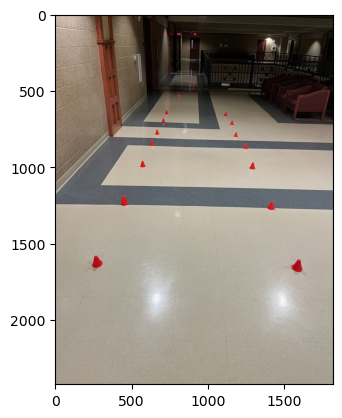

In [5]:
img = cv2.imread("red.png")
# In OpenCV we work with BGR for historical reasons
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# But for processing we want to use the L*a*b* colorspace
lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
# Let's make sure we did this right
imdisp(img)

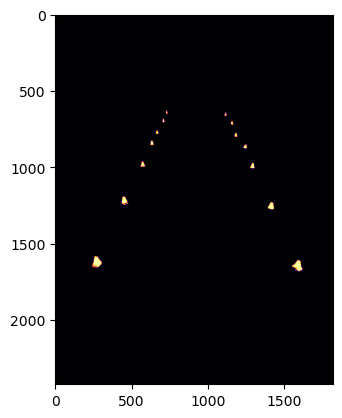

In [11]:
# We want to filter for the red color of the cones
# We can do a pretty good job of this since the a*
# axis of the L*a*b* colorspace tells you how red
# (or green) something is
COLOR_FILTER_LO = np.array([50, 160, 0])
COLOR_FILTER_HI = np.array([90, 255, 255])
mask = cv2.inRange(lab, COLOR_FILTER_LO, COLOR_FILTER_HI)
# Now, we need to "open" the mask to remove any
# speckle-like noise
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
imdisp(mask, cmap='inferno')

Found 9 cones.


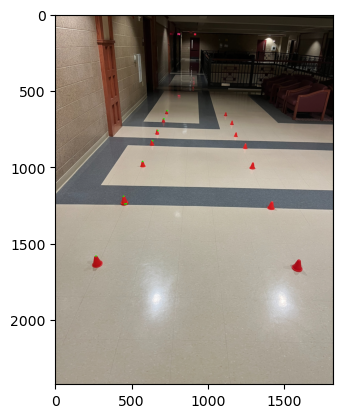

In [23]:
# First, we'll create an array to keep track
# fo the row above the one we're currently working
# with
row_size = mask[0].size
row_above = np.zeros(row_size, dtype=np.bool_)
# Of course, we'll need to keep track of the locations
# of the tips of the cones too, since that's the whole
# point of this segment
cones = []
# Now, we're going to loop through each row
for row_i, row in enumerate(mask):
    # Now we need to keep track of whether we've seen
    # a set pixel to the left of us or not (this is
    # kind of like the column analog of row_above)
    set_before = False
    # We'll also need to keep track of whether we've
    # rejected the fact that this is a new cone, which
    # occurs when it matches up with a set pixel above
    reject_new = False
    # Now, we'll loop through every index in the row
    for i in range(row_size):
        if row[i] and not set_before:
            # We found what might be the start of a
            # new cone
            set_before = True
            reject_new = False
        if set_before and row[i] and row_above[i]:
            # Never mind, the potential cone exists
            # above us and is one we've already seen
            reject_new = True
        elif set_before and not row[i] and not reject_new:
            # We found the end of a truly new cone
            set_before = False
            cones.append((i, row_i))
    # Don't forget to update row_above
    row_above = row
# Let's see how many cones we found
print(f"Found {len(cones)} cones.")
# Now, let's draw them on our image
img_with_cones = img.copy()
for coords in cones:
    cv2.circle(img_with_cones, coords, 5, (0, 255, 0), -1)
imdisp(img_with_cones)